# Reacher World!

This is the report for the Udacity Deep Reinforcement Learning Nanodegree continuous control project. See the `README.md` for a description of the Unity environment.

![Reacher_environment_solved](reacher_solved.png)

## Learning Algorithm

The algorithm used to solve the environment is PPO, as described in the [paper](https://arxiv.org/abs/1707.06347) and the Udacity lectures about clipped surrogate function and actor-critic methods.

Other resources consulted for the implementation are the Hugging Face [Deep RL Course](https://huggingface.co/learn/deep-rl-course) and the [CleanRL](https://github.com/vwxyzjn/cleanrl) implementation (with its wonderful [detailed explanation](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/)).

This implementation is notably different in various aspects and code structure (described below).

### Actor and Critic Networks

Both actor and critic networks are feed-forward neural networks with three fully-connected layers. The input size is the state size (i.e., `33` for the Reacher environment), and the hidden layer dimension is `32`. All activations are `tanh`, and the output layers are linear (i.e., there is no non-linearity processing the last linear layer output).

The critic output size is `1`, which represents the value estimate for the state(s) processed by the network. The actor output size is the action _continous space_ number of dimensions (i.e., `4` for the Reacher environment) and it represents the _mean_ value of the Gaussian distribution used to sample the continous action. Additionally for the actor, we train the standard deviation _Parameter_ for the such Gaussian distribution.

The two networks do not share layers.

#### Initialization

The neural network linear layers initialization is [`orthogonal`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.orthogonal_) and weights are scaled by a factor of `1e-3` (similar to the [DDPG pendulum](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/model.py) model).

Initially, the weight scaling seemed to affect the ability to learn. But as we can see in the appendix, that is not the case. It might have been a previous incorrect / buggy implementation of the PPO algorithm (e.g., wrong loss / returns / advantages) that caused this sensitivity to the initial conditions.

### PPO Implementation Details

#### Loss Function

The PPO loss as described in the paper is:

\begin{equation}
L_t^{CLIP + VF + S}(\theta) = \hat{\mathbb{E}_t}[L_t^{CLIP}(\theta) + c_1 L_t^{VF}(\theta) + c_2 S[\pi_\theta](s_t)]
\end{equation}

Which is a combined: policy loss + value loss + entropy loss. It is important to optimize a single loss function when the network share layers and weights.

But in this implementation, actor and critic networks are separate, so I opted to optimize the two loss functions $L_t^{CLIP}(\theta)$ and $L_t^{VF}(\theta)$ separately (no entropy added), much more similarly to the actor-critic network optimization of the Udacity lesson and examples.

Clipping policy updates (and gradient) happens as described in the PPO lesson (and the paper itself).

#### Training Loop

As wonderfully explained in the [CleanRL implementation details](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/) and the PPO paper itself, the PPO training loop is not based on episodes / max_steps. Instead, we keep collecting _trajectory segments_ and progressively train the agent on those. That enables to train in long-lasting environments as well.

The PPO training loop has been structured accordingly. But we exploit the Reacher environment specificities (i.e., constant `1001` steps episode duration for all bots) to be able to "even out" the trajectory segments (a.k.a., policy rollout steps) and determine if the environment is solved across `100` episodes.

See the `unity_env/README.md` for more details about the Reacher environment, and the code itself for the specifics.

Finally, the learning happens in mini-batches on every trajectory segment. Having an appropriate number of mini-batches is also very important for the algorithm to learn well and fast.

#### Generalized Advantage Estimation

GAE has been used and implemented according to the [paper](https://arxiv.org/abs/1506.02438). We reset the computation if the episode ends mid-way during a trajectory segment.

Also, the standard advantage estimation has been implemented: $A_t(s, a) = Q_t(s, a) - V_t(s)$. But training takes notably longer and it is slower to learn, though it keeps learning nonetheless.

### Hyperparameters

Hyperparameters have mostly standard values:

 * Policy training epochs: `10`
 * Number of mini-batches: `100`
 * Discount $\gamma$: `0.99`
 * GAE $\lambda$: `0.95`
 * Clip coefficient $\epsilon$: `0.1`
 * Entropy coefficient $c_2$: `0.0`
 * Maximum gradient clip: `0.5`
 * Learning rate $\alpha$: `lr=2.5e-4`
 * Neural network linear layer weight scaling factor: `1e-3`
 * Advantages normalization: `False`

## Training

Training runs for 125 episodes, after which it is considered solved because the average score for 100 episodes (across bots) is greater than `30.0`.

Let's import the necessary module to run the training:

In [2]:
from agent import Agent
from reacher import ReacherWorld
from ppo import PPO

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [3]:
# Utility plotting function
def plot(scores):
    """Plot scores and their running average."""
    avgs = pd.Series(scores).rolling(100).mean()
    x = np.arange(len(scores))
    plt.figure('Episode scores')
    plt.plot(x, scores, label='Scores')
    plt.plot(x, avgs, 'r', label='Running average')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [4]:
# Create the Reacher world!
reacher_world = ReacherWorld()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Let's train an agent!

In [4]:
main_agent = reacher_world.new_agent()
main_scores = reacher_world.train(main_agent)

Episode n.10 completed. Avg score: 2.1284999847412117
Episode n.20 completed. Avg score: 4.8529996871948243
Episode n.30 completed. Avg score: 8.5355005264282235
Episode n.40 completed. Avg score: 15.140498161315918
Episode n.50 completed. Avg score: 24.140499114990234
Episode n.60 completed. Avg score: 28.868495941162114
Episode n.70 completed. Avg score: 33.822990417480474
Episode n.80 completed. Avg score: 36.413494110107424
Episode n.90 completed. Avg score: 38.019496917724614
Episode n.100 completed. Avg score: 38.47599411010742
Episode n.110 completed. Avg score: 37.42599105834961
Episode n.120 completed. Avg score: 37.963497161865234
Reacher environment solved at episode 125! 100 episodes score: 30.18080159664154


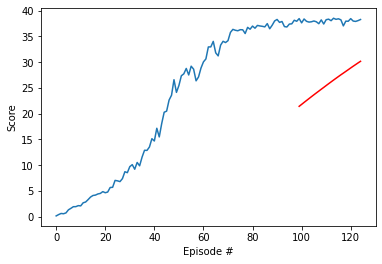

In [6]:
plot(main_scores)

## Future Improvements

Here are some ideas for future improvements on this project:

 * Neural network sharing layers: share layers between actor and critic, and use PPO loss function.
 * Neural network initialization: figure out how weights initialization affects learning precisely, and try out different architectures.
 * Implement learning rate annealing.
 * Try this PPO implementation in different environments, and generalize it to accept different networks.
 * Explore different ways of determining rewards, e.g., include [_curiosity_](https://pathak22.github.io/large-scale-curiosity/).

### Standard Returns Computation vs. GAE

With standard return computation we can see that learning is much slower.

## Appendix: Comparisons and Variations

Let's compare what happens with different hyperparameters... it is fun to see the struggle to get this right :) Also, just 50 episodes to not take forever!

### Standard Advantages Computation vs. GAE

With standard advantages computation, learning is much slower (though consistent).

Episode n.10 completed. Avg score: 1.2154998779296875
Episode n.20 completed. Avg score: 2.2984998226165778
Episode n.30 completed. Avg score: 2.9419999122619636
Episode n.40 completed. Avg score: 3.0039999485015878
Episode n.50 completed. Avg score: 3.3349997997283936
Reached the maximum number of episodes, terminating...


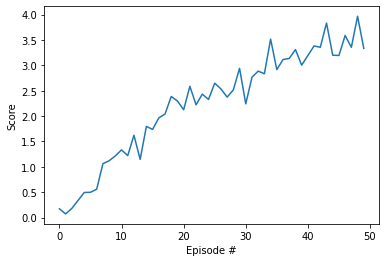

In [4]:
agent = reacher_world.new_agent()
scores = reacher_world.train(agent, max_episodes=50, gae_enabled=False)
plot(scores)

### Network Weights Standard Initialization

Not rescaling linear layers seems to make learning faster in the first episodes and slow down later on. But learning seems to keep happening (contrary to the initial hypothesis that it might actually prevent it).

Episode n.10 completed. Avg score: 3.0894999504089355
Episode n.20 completed. Avg score: 7.2184996604919435
Episode n.30 completed. Avg score: 9.1229991912841815
Episode n.40 completed. Avg score: 12.684498786926272
Episode n.50 completed. Avg score: 15.965497970581055
Reached the maximum number of episodes, terminating...


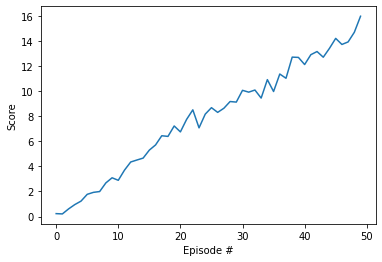

In [5]:
agent = reacher_world.new_agent(weight_mul=1.0)
scores = reacher_world.train(agent, max_episodes=50)
plot(scores)

### Train A Single Batch

Training across the entire segment (instead of mini-batches) incredibly slows down policy learning, to the point that it seems to prevent it (though it should still be happening).

This could be expected given that we perform a single update to the policy with all the collected data at once, instead of iterating and performing many smaller stochastic updates.

Episode n.10 completed. Avg score: 0.0820000022649765
Episode n.20 completed. Avg score: 0.06499999761581421
Episode n.30 completed. Avg score: 0.18549999594688416
Episode n.40 completed. Avg score: 0.125999987125396735
Episode n.50 completed. Avg score: 0.14649999141693115
Reached the maximum number of episodes, terminating...


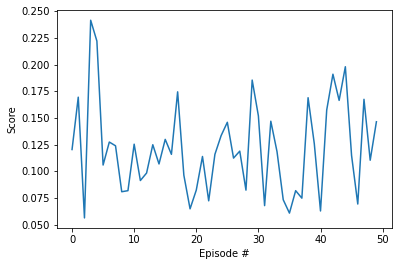

In [6]:
agent = reacher_world.new_agent()
scores = reacher_world.train(agent, max_episodes=50, n_mini_batches=1)
plot(scores)